# Re-creating Weinberg et al. 2017 one-zone model results in VICE

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter, NullFormatter
import vice
from vice.yields.sneia import iwamoto99

# VICE yields settings
vice.yields.ccsne.settings['o'] = 0.015
vice.yields.ccsne.settings['fe'] = 0.0012

# Plot settings
plt.rc(('xtick', 'ytick'), direction='in')
plt.rc(('xtick.minor', 'ytick.minor'), size=4)
plt.rc(('xtick.major', 'ytick.major'), size=8)
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('font', family='STIXgeneral')
plt.rc('figure', dpi=140)
plt.rc('figure', figsize=(4, 4))

In [31]:
# Set up multiple models
names = ['W17_fid', 'W17_long_sfh', 'W17_short_sfh', 'W17_linexp', 'W17_short_ia', 'W17_long_ia', 'W17_short_delay', 'W17_long_delay']
tau_sfh = [6, 40, 2.5, 2.5, 6, 6, 6, 6] # star formation timescale [Gyr]
tau_ia = [1.5, 1.5, 1.5, 1.5, 0.5, 4.5, 1.5, 1.5]
delay = [0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.05, 0.45]

for i, name in enumerate(names):
    sz = vice.singlezone(name=name)

    def exp_sfr(t):
        """Exponentially declining star formation rate."""
        sfr = np.exp(-t/tau_sfh[i])
        if name == 'W17_linexp':
            sfr *= t
        return sfr

    sz.func = exp_sfr
    sz.mode = 'sfr'
    sz.elements = ('fe', 'o')
    sz.IMF = 'kroupa'
    sz.eta = 2.5 # mass-loading parameter, or ratio of outflow rate to star formation rate
    sz.recycling = 0.4 # recycling parameter, fraction of stellar mass from CCSNe and AGB stars returned at original metallicity
    sz.delay = delay[i] # delay time of onset of SNe Ia [Gyr]
    sz.RIa = 'exp' # SN Ia DTD
    sz.tau_ia = tau_ia[i] # exponential SN Ia timescale [Gyr]
    sz.tau_star = 1 # SFE timescale, ratio of current gas mass to star formation rate [Gyr]
    
    sz.run(np.linspace(0, 12.5, 1251), overwrite=True)

In [32]:
history = vice.history('W17_fid')
mdf = vice.mdf('W17_fid')
print(history)
print(mdf)

vice.dataframe{
    time -----------> [0, 0.01, 0.02, ... , 12.48, 12.49, 12.5]
    mgas -----------> [1e+09, 9.98335e+08, 9.96672e+08, ... , 1.2493e+08, 1.24722e+08, 1.24514e+08]
    mstar ----------> [0, 7.98718e+06, 1.57558e+07, ... , 3.04593e+09, 3.04647e+09, 3.04701e+09]
    sfr ------------> [1, 0.998335, 0.996672, ... , 0.12493, 0.124722, 0.124515]
    ifr ------------> [nan, 2.92831, 2.92343, ... , 0.366445, 0.365834, 0.365225]
    ofr ------------> [2.5, 2.49584, 2.49168, ... , 0.312325, 0.311805, 0.311286]
    eta_0 ----------> [2.5, 2.5, 2.5, ... , 2.5, 2.5, 2.5]
    r_eff ----------> [0.4, 0.4, 0.4, ... , 0.4, 0.4, 0.4]
    z_in(fe) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(o) --------> [0, 0, 0, ... , 0, 0, 0]
    z_out(fe) ------> [0, 1.16293e-05, 2.29183e-05, ... , 0.0011678, 0.00116781, 0.00116782]
    z_out(o) -------> [8.57303e-320, 0.000145367, 0.000286452, ... , 0.00507529, 0.00507529, 0.00507529]
    mass(fe) -------> [0, 11610, 22842, ... , 145894, 145652, 145411

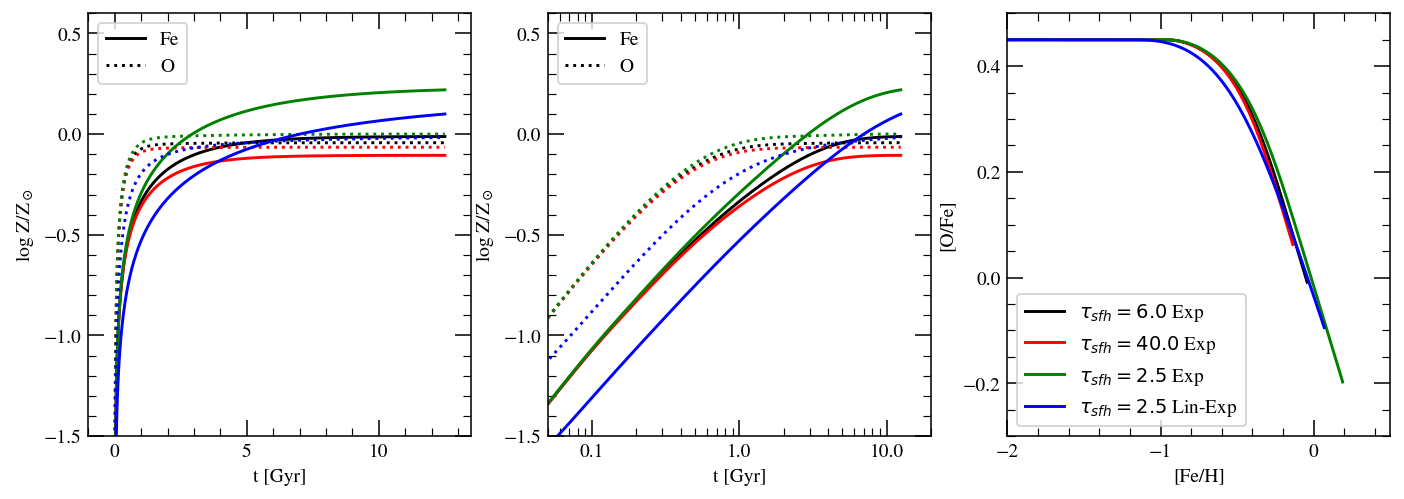

In [58]:
# Abundance evolution and O-Fe tracks, adjusting star formation history
z_fe_sun = 0.0012
z_o_sun = 0.0056

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot other tracks
names = ['W17_fid', 'W17_long_sfh', 'W17_short_sfh', 'W17_linexp']
colors = ['k', 'r', 'g', 'b']
labels = ['$\\tau_{sfh}=6.0$ Exp', '$\\tau_{sfh}=40.0$ Exp', '$\\tau_{sfh}=2.5$ Exp', '$\\tau_{sfh}=2.5$ Lin-Exp']
for i, name in enumerate(names):
    history = vice.history(name)
    axs[0].plot(history['time'][1:], np.log10(np.array(history['z(fe)'][1:])/z_fe_sun), c=colors[i], label='Fe')
    axs[0].plot(history['time'][1:], np.log10(np.array(history['z(o)'][1:])/z_o_sun), c=colors[i], linestyle=':', label='O')
    axs[1].plot(history['time'][1:], np.log10(np.array(history['z(fe)'][1:])/z_fe_sun), c=colors[i], label='Fe')
    axs[1].plot(history['time'][1:], np.log10(np.array(history['z(o)'][1:])/z_o_sun), c=colors[i], linestyle=':', label='O')
    axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], c=colors[i], label=labels[i])

# Format plot
ax = axs[0]
ax.set_xlim((-1, 13.5))
ax.set_ylim((-1.5, 0.6))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xlabel('t [Gyr]')
ax.set_ylabel('log Z/Z$_\odot$')
ax.legend(['Fe', 'O'], loc='upper left')

ax = axs[1]
ax.set_xscale('log')
ax.set_xlim((0.05, 20))
ax.set_ylim((-1.5, 0.6))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xlabel('t [Gyr]')
ax.set_ylabel('log Z/Z$_\odot$')
ax.legend(['Fe', 'O'], loc='upper left')

ax = axs[2]
ax.set_xlim((-2, 0.5))
ax.set_ylim((-0.3, 0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend(loc='lower left')

plt.show()

vice.dataframe{
    fe -------------> 0.0012
    o --------------> 0.015
}


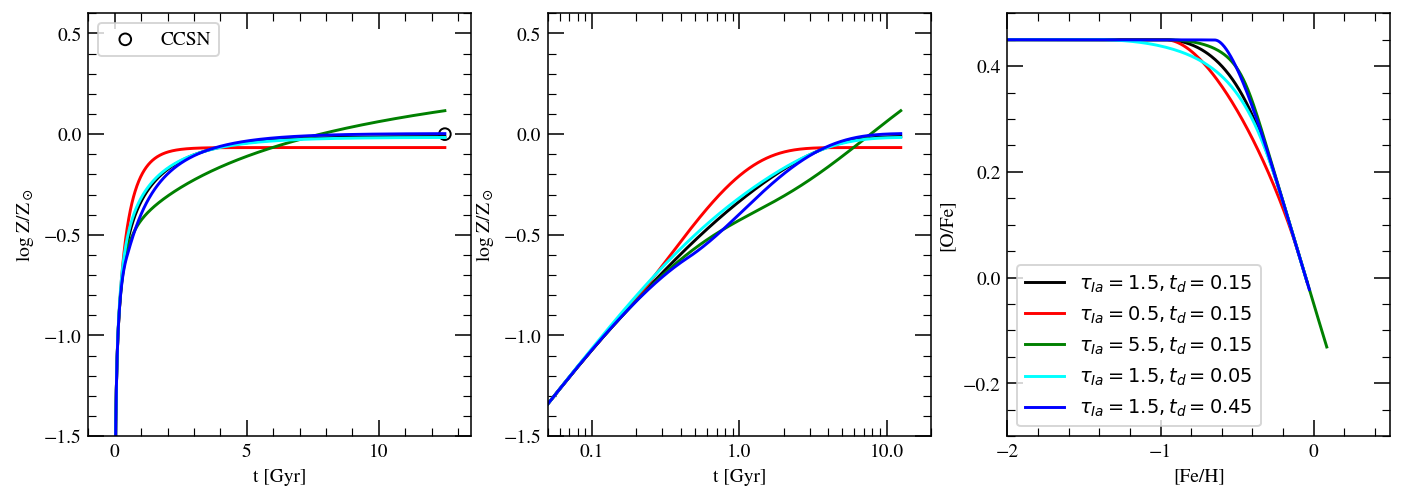

In [71]:
# Abundance evolution and O-Fe tracks, adjusting SN Ia DTD
z_fe_sun = 0.0012
z_o_sun = 0.0056

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot other tracks
names = ['W17_fid', 'W17_short_ia', 'W17_long_ia', 'W17_short_delay', 'W17_long_delay']
colors = ['k', 'r', 'g', 'cyan', 'b']
labels = ['$\\tau_{Ia}=1.5, t_d=0.15$', '$\\tau_{Ia}=0.5, t_d=0.15$', '$\\tau_{Ia}=5.5, t_d=0.15$', '$\\tau_{Ia}=1.5, t_d=0.05$', '$\\tau_{Ia}=1.5, t_d=0.45$']
for i, name in enumerate(names):
    history = vice.history(name)
    axs[0].plot(history['time'][1:], np.log10(np.array(history['z(fe)'][1:])/z_fe_sun), c=colors[i])
    axs[1].plot(history['time'][1:], np.log10(np.array(history['z(fe)'][1:])/z_fe_sun), c=colors[i])
    axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], c=colors[i], label=labels[i])

# Format plot
ax = axs[0]
ccsne_yields = vice.output('W17_fid').ccsne_yields
print(ccsne_yields)
ax.scatter(history['time'][-1], np.log10(ccsne_yields['fe']/z_fe_sun), marker='o', facecolors='none', edgecolors='k', label='CCSN')
ax.set_xlim((-1, 13.5))
ax.set_ylim((-1.5, 0.6))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xlabel('t [Gyr]')
ax.set_ylabel('log Z/Z$_\odot$')
ax.legend(loc='upper left')

ax = axs[1]
ax.set_xscale('log')
ax.set_xlim((0.05, 20))
ax.set_ylim((-1.5, 0.6))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xlabel('t [Gyr]')
ax.set_ylabel('log Z/Z$_\odot$')

ax = axs[2]
ax.set_xlim((-2, 0.5))
ax.set_ylim((-0.3, 0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend(loc='lower left')

plt.show()

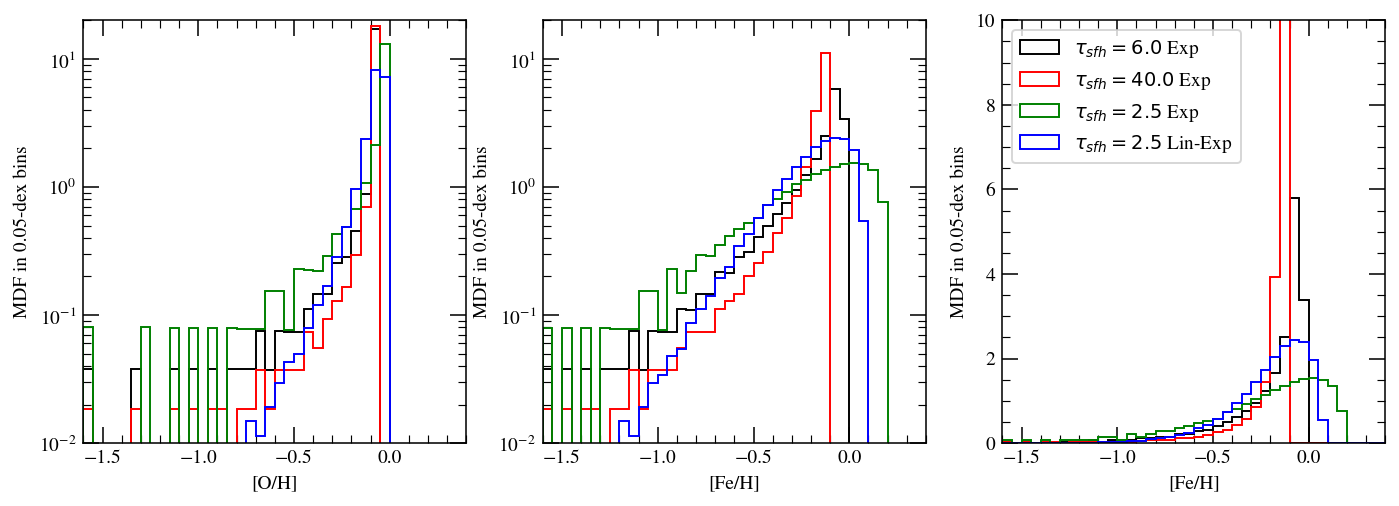

In [50]:
# Metallicity Distribution Functions (MDFs)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

names = ['W17_fid', 'W17_long_sfh', 'W17_short_sfh', 'W17_linexp']
colors = ['k', 'r', 'g', 'b']
labels = ['$\\tau_{sfh}=6.0$ Exp', '$\\tau_{sfh}=40.0$ Exp', '$\\tau_{sfh}=2.5$ Exp', '$\\tau_{sfh}=2.5$ Lin-Exp']
for i, name in enumerate(names):
    mdf = vice.mdf(name)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    axs[0].hist(mdf['bin_edge_left'], weights=mdf['dn/d[o/h]'], bins=bins, histtype='step', color=colors[i])
    axs[1].hist(mdf['bin_edge_left'], weights=mdf['dn/d[fe/h]'], bins=bins, histtype='step', color=colors[i])
    axs[2].hist(mdf['bin_edge_left'], weights=mdf['dn/d[fe/h]'], bins=bins, histtype='step', color=colors[i], label=labels[i])

ax = axs[0]
# ax.hist(mdf['bin_edge_left'], weights=mdf['dn/d[o/h]'], bins=bins, histtype='step', color='k')
ax.set_yscale('log')
ax.set_xlim((-1.6, 0.4))
ax.set_ylim((0.01, 20))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xlabel('[O/H]')
ax.set_ylabel('MDF in 0.05-dex bins')

ax = axs[1]
# ax.hist(mdf['bin_edge_left'], weights=mdf['dn/d[fe/h]'], bins=bins, histtype='step', color='k')
ax.set_yscale('log')
ax.set_xlim((-1.6, 0.4))
ax.set_ylim((0.01, 20))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('MDF in 0.05-dex bins')

ax = axs[2]
# ax.hist(mdf['bin_edge_left'], weights=mdf['dn/d[fe/h]'], bins=bins, histtype='step', color='k')
ax.set_xlim((-1.6, 0.4))
ax.set_ylim((0, 10))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('MDF in 0.05-dex bins')
ax.legend(loc='upper left')

plt.show()